In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm
import wandb

/usr0/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
pd.options.display.max_rows = 150

In [3]:
api = wandb.Api(timeout=20)

In [4]:
filters = {
    "state": "finished"
}

# runs = api.runs("flow-graphs-cmu/flow_graphs-code", filters=filters)


## re-run risec and chemu
# sweeps = [
#     "zt62jnek", # RISEC multiseed, all. fewshot 1-10
#     "2fvdobq5", #  RISEC single seed, fewshot 1-10
#     "v57twc84", # RISEC AMR only, multiseed, fewshot 1-10
#     "cb3sa5r1", # Chemu multiseed, AMR only. fewshot 1-50. 
#     "d7163mab" # Chemu multiseed, all. fewshot 1-50
# ]

# from-scratch sweep
sweeps = ["yk2y8xqg"]


runs = []
for sweep_id in sweeps:
    sweep = api.sweep(f"flow-graphs-cmu/flow_graphs-code/{sweep_id}")
    runs.extend([run for run  in sweep.runs if "incorrect_amr" not in run.tags])

In [5]:
df_dicts = []

for run in tqdm(runs):
    try:
        test_f1  = run.history(keys=["test_f1"], pandas=False)[0]["test_f1"]
        dep = run.history(keys=["dep"], pandas=False)[0]["dep"]
        amr = run.history(keys=["amr"], pandas=False)[0]["amr"]
        df_dicts.append({**run.config, "test_f1": test_f1, "amr": amr, "dep": dep})
    except:
        continue

results_df = pd.DataFrame(df_dicts)

  0%|          | 0/820 [00:00<?, ?it/s]

In [13]:
dataset_name_mapping = {
    "risec": "RISeC",
    "japflow": "Cooking Flow Graphs",
    "chemu": "Chemical Patents",
    "mscorpus": "Materials Science",
}

In [14]:
results_df["case"] = ""
results_df["case"][results_df["dep"] == '0'] = "baseline"
results_df["case"][results_df["dep"] == '1'] = "dep"
results_df["case"][results_df["amr"] == '1'] = "amr"
results_df

/usr0/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr0/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr0/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,amr,dep,seed,fewshot,src_dataset,tgt_dataset,test_f1,case
0,1,1,2,0.50,japflow,risec,0.762131,amr
1,1,1,2,0.50,risec,mscorpus,0.828333,amr
2,1,1,1,0.50,mscorpus,risec,0.670113,amr
3,1,1,1,0.50,chemu,mscorpus,0.823745,amr
4,1,1,1,0.50,chemu,japflow,0.693629,amr
...,...,...,...,...,...,...,...,...
389,0,0,0,0.01,chemu,risec,0.109090,baseline
390,0,0,0,0.01,japflow,mscorpus,0.369100,baseline
391,0,0,0,0.01,japflow,risec,0.124179,baseline
392,0,0,0,0.01,risec,mscorpus,0.364649,baseline


In [21]:
results_df.shape

(394, 8)

In [23]:
results_df.groupby(["src_dataset", "tgt_dataset", "fewshot", "case"])["test_f1"].aggregate(["count", "mean", "std"])

count      mean       std
src_dataset tgt_dataset fewshot case                               
chemu       japflow     0.01    amr           3  0.093436  0.036560
                                baseline      3  0.116941  0.055469
                                dep           3  0.091070  0.027289
                        0.05    amr           3  0.446246  0.011791
                                baseline      3  0.438920  0.010937
                                dep           3  0.437121  0.011935
                        0.10    amr           3  0.503136  0.024764
                                baseline      3  0.531390  0.017018
                                dep           3  0.507162  0.015105
                        0.20    amr           3  0.620450  0.008823
                                baseline      3  0.603516  0.016732
                                dep           3  0.600695  0.015914
                        0.50    amr           2  0.696464  0.004009
                                baseline      3  0.690759  0.010738
                                dep           3  0.694575  0.008719
            mscorpus    0.01    amr           3  0.320788  0.016646
                                baseline      3  0.233384  0.105534
                                dep           3  0.303158  0.060173
                        0.05    amr           3  0.559685  0.049849
                                baseline      3  0.579214  0.032061
                                dep           3  0.532981  0.022258
                        0.10    amr           3  0.667576  0.042677
                                baseline      3  0.678186  0.024303
                                dep           3  0.637176  0.014484
                        0.20    amr           3  0.755042  0.028758
                                baseline      3  0.766536  0.027200
                                dep           3  0.759633  0.011369
                        0.50    amr           2  0.830152  0.009061
                                baseline      3  0.828466  0.006683
                                dep           3  0.830343  0.009505
            risec       0.01    amr           3  0.086123  0.027146
                                baseline      3  0.116088  0.008076
                                dep           3  0.090479  0.025952
                        0.05    amr           3  0.227559  0.135839
                                baseline      3  0.194004  0.068025
                                dep           3  0.166136  0.121779
                        0.10    amr           3  0.359645  0.005577
                                baseline      3  0.341443  0.007329
                                dep           3  0.356359  0.005445
                        0.20    amr           3  0.480373  0.035242
                                baseline      3  0.411039  0.244568
                                dep           3  0.494146  0.035016
                        0.50    amr           2  0.752189  0.006280
                                baseline      3  0.688340  0.037427
                                dep           3  0.666574  0.045586
japflow     mscorpus    0.01    amr           3  0.375565  0.017042
                                baseline      3  0.373456  0.029864
                                dep           3  0.370601  0.007158
                        0.05    amr           3  0.597438  0.031774
                                baseline      3  0.600322  0.002725
                                dep           3  0.611039  0.004280
                        0.10    amr           3  0.690977  0.026220
                                baseline      3  0.657847  0.025790
                                dep           3  0.699092  0.009888
                        0.20    amr           3  0.768168  0.008883
                                baseline      3  0.768871  0.010916
                                dep           3  0.778520  0.016101
                        0.50  

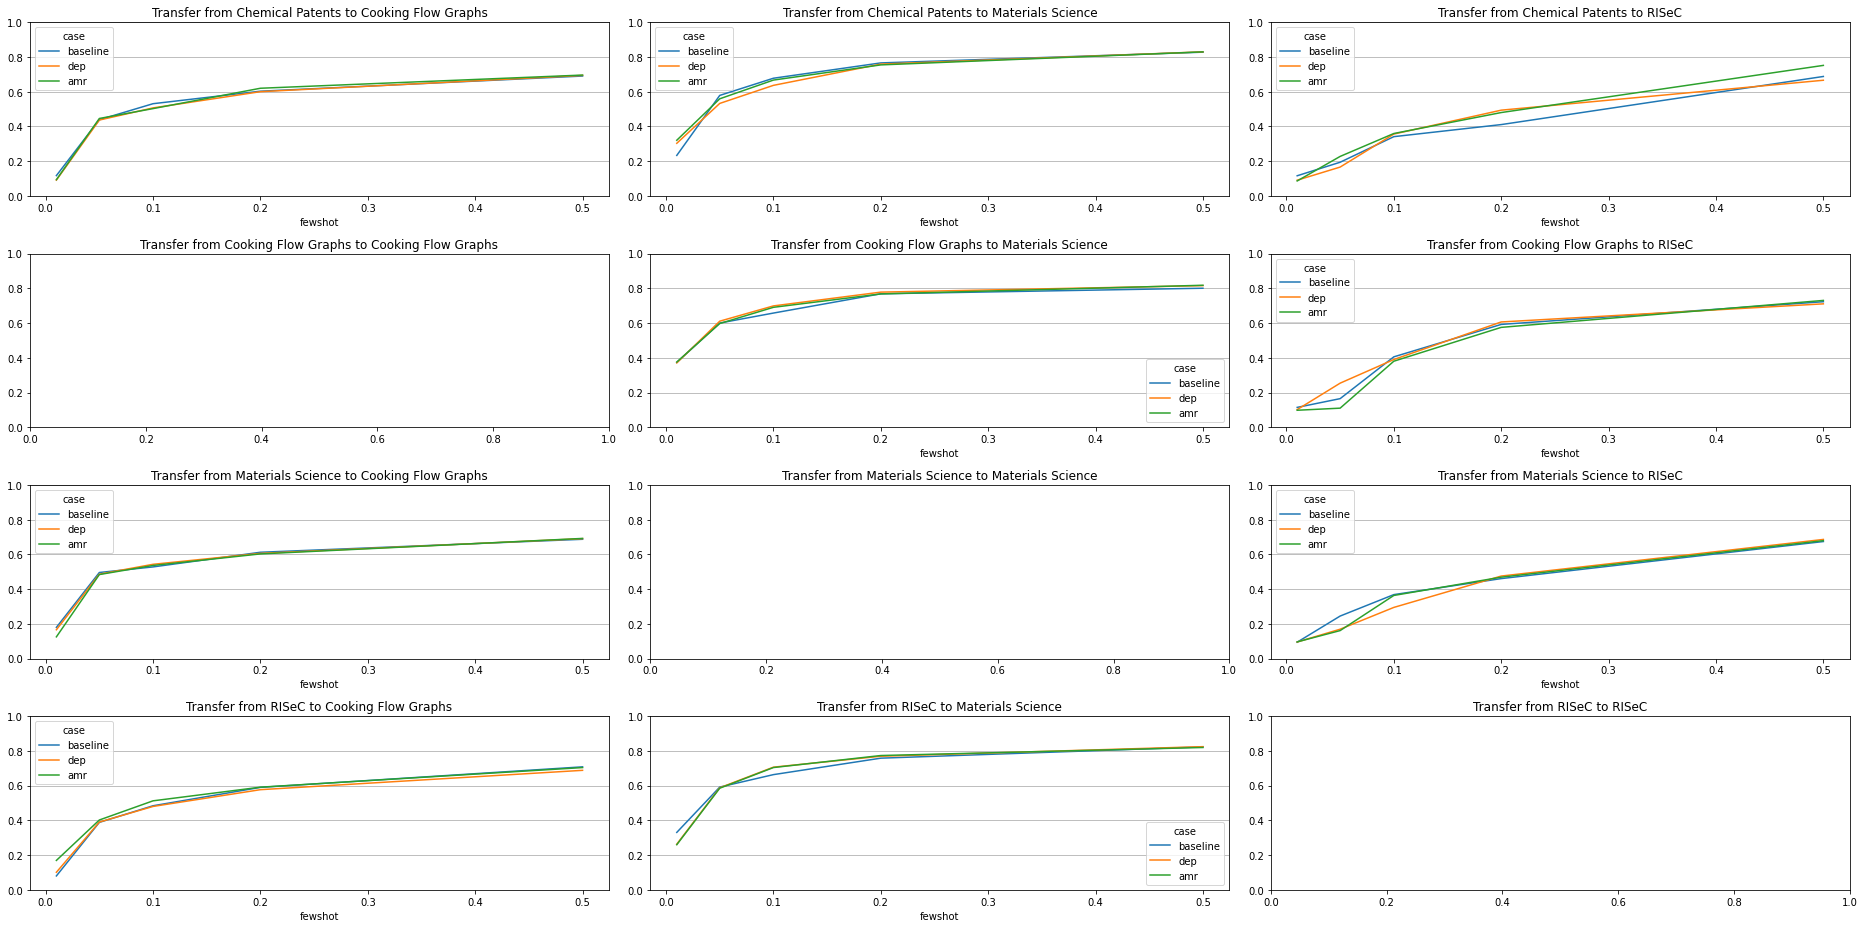

In [17]:
src_datasets = set(results_df["src_dataset"])
tgt_datasets = set(results_df["tgt_dataset"])

fig, axes = plt.subplots(len(src_datasets),len(tgt_datasets), figsize=(26, 13), tight_layout=True)
ax_iter = iter(axes.reshape([-1]))

for src_dataset in sorted(src_datasets):
    for tgt_dataset in sorted(tgt_datasets):
        ax = next(ax_iter)
        ax.set_title(f"Transfer from {dataset_name_mapping[src_dataset]} to {dataset_name_mapping[tgt_dataset]}")
        ax.set_ylim(0, 1)
        if src_dataset == tgt_dataset:
            continue
        results_viz = results_df[(results_df["src_dataset"] == src_dataset) & (results_df["tgt_dataset"] == tgt_dataset)].groupby(["fewshot", "case"])["test_f1"].aggregate(["mean"]).unstack(1)       
        results_viz.columns = results_viz.columns.droplevel()
        graph = results_viz[["baseline", "dep", "amr"]].plot(ax=ax)
        graph.grid(axis="y", which="both")
        for bars in ax.containers:
            ax.bar_label(bars, fmt="%2.2f")
